In [1]:
import os
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/home/adedapo/personal_project/daps05ayoade/disseration')

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from algotrading.ml_logic.scraping_data import get_stock_data
from algotrading.ml_logic.preprocessing import window
from algotrading.strategy.data_fetcher import DataFetcher
from algotrading.secrecy import API_TOKEN, API_KEY, SECRET_KEY

2023-08-11 20:04:37.828943: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-11 20:04:37.830435: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-11 20:04:37.862545: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-11 20:04:37.863753: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 20:04:38.610380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
symbol = 'INTC'

# Get the stock data
stock_data = get_stock_data(symbol)

# Preprocess the data
X_train, y_train, X_val, y_val, X_test, y_test, sc = window(stock_data)

In [3]:
stock_data.tail()

,open,high,low,close,adj_close,volume,dividend_amount,SMA,RSI,ADX,CCI,ATR,EMA,SPY,VIXY,target
2023-08-04,34.48,35.5600,34.48,35.14,35.14,26674897.0,0.125,32.3589,53.8608,9.4722,93.1496,1.0727,32.8175,446.81,25.86,35.23
2023-08-07,35.41,35.5500,34.75,35.23,35.23,22486870.0,0.000,32.4460,54.9972,9.5123,94.7717,1.0681,32.9025,450.71,24.50,35.02
2023-08-08,34.67,35.1000,33.86,35.02,35.02,34753598.0,0.000,32.5322,53.9225,9.5010,74.9044,1.0732,32.9605,448.75,25.04,34.28
2023-08-09,35.00,35.0999,34.23,34.28,34.28,28720157.0,0.000,32.6335,54.3273,9.4899,68.8686,1.0698,33.0273,445.75,24.78,34.68
2023-08-10,34.70,35.0900,34.48,34.68,34.68,30957295.0,0.000,32.7319,53.8897,9.4789,74.9392,1.0655,33.0822,445.91,24.87,34.89


In [4]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'X_val: {X_val.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')
print(f'y_val: {y_val.shape}')

X_train: (2159, 60, 15)
X_test: (417, 60, 15)
X_val: (415, 60, 15)
y_train: (2159,)
y_test: (417,)
y_val: (415,)


In [5]:
batch_size=15
epochs=1000

# Save the scaler for the ticker
with open(f'/home/adedapo/personal_project/daps05ayoade/disseration/alternative-scaler/scaler_{symbol}.pkl', 'wb') as file:
    pickle.dump(sc, file)

# Model: RNN

In [6]:
# Define the RNN model
rnn = Sequential()

# Add the first SimpleRNN layer
rnn.add(SimpleRNN(units=30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a second SimpleRNN layer
rnn.add(SimpleRNN(units=30, return_sequences=False))

# Add a Dense layer
rnn.add(Dense(units=25))

# Output layer
rnn.add(Dense(units=1))

# Compile model
rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Checkpoint callback to save best model during training
checkpoint_filepath = f'/home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_rnn_model_{symbol}.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mae', save_best_only=True, verbose=1)

# Early stopping callback to stop training when Mean Absolute Error stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

# Fit and train model
rnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/1000
143/144 [============================>.] - ETA: 0s - loss: 301.2748 - mae: 13.5995
Epoch 1: val_mae improved from inf to 23.97485, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_rnn_model_INTC.h5
144/144 [==============================] - 4s 22ms/step - loss: 300.1449 - mae: 13.5744 - val_loss: 601.8206 - val_mae: 23.9749
Epoch 2/1000
142/144 [============================>.] - ETA: 0s - loss: 41.2510 - mae: 4.1044
Epoch 2: val_mae improved from 23.97485 to 10.19539, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_rnn_model_INTC.h5
144/144 [==============================] - 3s 17ms/step - loss: 40.7645 - mae: 4.0693 - val_loss: 130.3854 - val_mae: 10.1954
Epoch 3/1000
141/144 [============================>.] - ETA: 0s - loss: 2.3971 - mae: 1.0023
Epoch 3: val_mae improved from 10.19539 to 7.24557, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternativ

144/144 [==============================] - ETA: 0s - loss: 0.5992 - mae: 0.5446
Epoch 23: val_mae improved from 2.71803 to 2.56657, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_rnn_model_INTC.h5
144/144 [==============================] - 2s 15ms/step - loss: 0.5992 - mae: 0.5446 - val_loss: 12.5673 - val_mae: 2.5666
Epoch 24/1000
141/144 [============================>.] - ETA: 0s - loss: 0.6006 - mae: 0.5463
Epoch 24: val_mae did not improve from 2.56657
144/144 [==============================] - 2s 15ms/step - loss: 0.6016 - mae: 0.5492 - val_loss: 12.5330 - val_mae: 2.5769
Epoch 25/1000
144/144 [==============================] - ETA: 0s - loss: 0.6089 - mae: 0.5643
Epoch 25: val_mae did not improve from 2.56657
144/144 [==============================] - 2s 15ms/step - loss: 0.6089 - mae: 0.5643 - val_loss: 12.5576 - val_mae: 2.6163
Epoch 26/1000
144/144 [==============================] - ETA: 0s - loss: 0.5632 - mae: 0.5301
Epoch 26:

Epoch 51/1000
142/144 [============================>.] - ETA: 0s - loss: 0.5835 - mae: 0.5460
Epoch 51: val_mae did not improve from 1.99338
144/144 [==============================] - 3s 23ms/step - loss: 0.5825 - mae: 0.5463 - val_loss: 10.2799 - val_mae: 2.3708
Epoch 52/1000
143/144 [============================>.] - ETA: 0s - loss: 0.5530 - mae: 0.5229
Epoch 52: val_mae did not improve from 1.99338
144/144 [==============================] - 3s 23ms/step - loss: 0.5531 - mae: 0.5232 - val_loss: 10.2774 - val_mae: 2.3807
Epoch 53/1000
143/144 [============================>.] - ETA: 0s - loss: 0.5452 - mae: 0.5190
Epoch 53: val_mae did not improve from 1.99338
144/144 [==============================] - 3s 24ms/step - loss: 0.5430 - mae: 0.5180 - val_loss: 8.8094 - val_mae: 2.1087
Epoch 54/1000
142/144 [============================>.] - ETA: 0s - loss: 0.5599 - mae: 0.5305
Epoch 54: val_mae did not improve from 1.99338
144/144 [==============================] - 4s 25ms/step - loss: 0.56

141/144 [============================>.] - ETA: 0s - loss: 0.4956 - mae: 0.4933
Epoch 82: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 14ms/step - loss: 0.4948 - mae: 0.4933 - val_loss: 9.7571 - val_mae: 2.2324
Epoch 83/1000
141/144 [============================>.] - ETA: 0s - loss: 0.4857 - mae: 0.4974
Epoch 83: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 14ms/step - loss: 0.4920 - mae: 0.4979 - val_loss: 10.7701 - val_mae: 2.3636
Epoch 84/1000
141/144 [============================>.] - ETA: 0s - loss: 0.5101 - mae: 0.5054
Epoch 84: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 14ms/step - loss: 0.5095 - mae: 0.5064 - val_loss: 10.6030 - val_mae: 2.3784
Epoch 85/1000
141/144 [============================>.] - ETA: 0s - loss: 0.5157 - mae: 0.5049
Epoch 85: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 14ms/step - loss: 0.5124 - mae: 0.50

Epoch 113/1000
143/144 [============================>.] - ETA: 0s - loss: 0.4962 - mae: 0.5065
Epoch 113: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 15ms/step - loss: 0.4960 - mae: 0.5067 - val_loss: 14.0074 - val_mae: 2.8685
Epoch 114/1000
142/144 [============================>.] - ETA: 0s - loss: 0.4765 - mae: 0.4908
Epoch 114: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 15ms/step - loss: 0.4844 - mae: 0.4925 - val_loss: 11.7047 - val_mae: 2.5135
Epoch 115/1000
143/144 [============================>.] - ETA: 0s - loss: 0.5384 - mae: 0.5249
Epoch 115: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 15ms/step - loss: 0.5368 - mae: 0.5242 - val_loss: 15.4601 - val_mae: 3.0650
Epoch 116/1000
143/144 [============================>.] - ETA: 0s - loss: 0.4740 - mae: 0.4890
Epoch 116: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 17ms/step - l

Epoch 144/1000
143/144 [============================>.] - ETA: 0s - loss: 0.4548 - mae: 0.4793
Epoch 144: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 16ms/step - loss: 0.4555 - mae: 0.4801 - val_loss: 13.5115 - val_mae: 2.7706
Epoch 145/1000
144/144 [==============================] - ETA: 0s - loss: 0.4897 - mae: 0.5013
Epoch 145: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 16ms/step - loss: 0.4897 - mae: 0.5013 - val_loss: 14.6894 - val_mae: 2.9107
Epoch 146/1000
143/144 [============================>.] - ETA: 0s - loss: 0.4791 - mae: 0.4916
Epoch 146: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 17ms/step - loss: 0.4786 - mae: 0.4915 - val_loss: 13.0850 - val_mae: 2.7022
Epoch 147/1000
144/144 [==============================] - ETA: 0s - loss: 0.5106 - mae: 0.5256
Epoch 147: val_mae did not improve from 1.99338
144/144 [==============================] - 2s 17ms/step - l

In [7]:
y_pred = rnn.predict(X_test)
result = pd.DataFrame(data={'Prediction': y_pred.flatten(), 'Actuals': y_test})
result.tail()

14/14 [==============================] - 0s 7ms/step


,Prediction,Actuals
412,36.513969,35.23
413,37.702644,35.02
414,37.619732,34.28
415,36.454597,34.68
416,36.441048,34.89


In [8]:
# Evaluate the model
loss = rnn.evaluate(X_test, y_test)
print('Test loss:', loss)

14/14 [==============================] - 0s 6ms/step - loss: 3.0656 - mae: 1.4029
Test loss: [3.065585136413574, 1.4028853178024292]


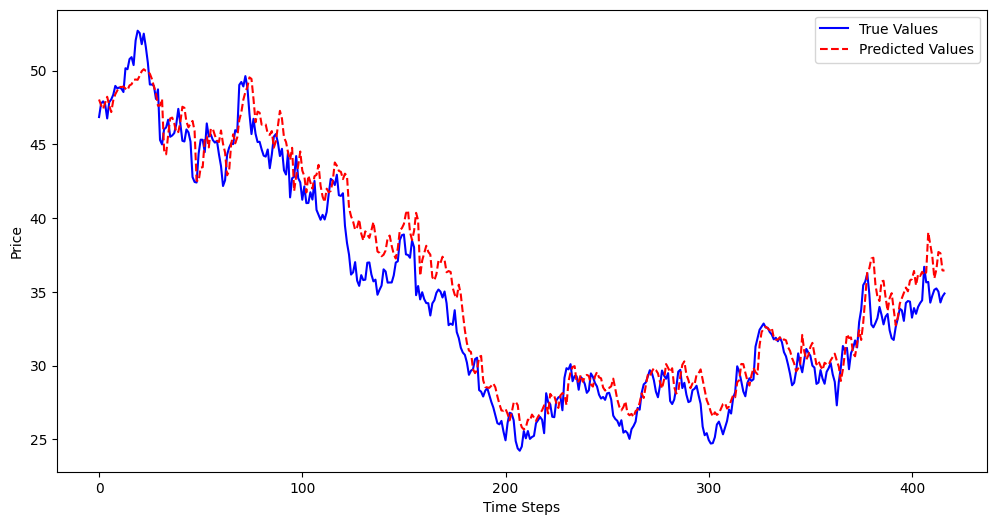

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

# Model: LSTM

In [10]:
# Define the LSTM model
lstm = Sequential()

# Add the first LSTM layer
lstm.add(LSTM(units=30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a second LSTM layer
lstm.add(LSTM(units=30, return_sequences=False))

# Add a Dense layer
lstm.add(Dense(units=25))

# Output layer
lstm.add(Dense(units=1))

# Compile model
lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Checkpoint callback to save best model during training
checkpoint_filepath = f'/home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_lstm_model_{symbol}.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mae', save_best_only=True, verbose=1)

# Early stopping callback to stop training when Mean Absolute Error stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

# Fit and train model
lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/1000
144/144 [==============================] - ETA: 0s - loss: 263.0266 - mae: 12.7200
Epoch 1: val_mae improved from inf to 23.63129, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_lstm_model_INTC.h5
144/144 [==============================] - 8s 35ms/step - loss: 263.0266 - mae: 12.7200 - val_loss: 585.3158 - val_mae: 23.6313
Epoch 2/1000
143/144 [============================>.] - ETA: 0s - loss: 43.3903 - mae: 4.3338
Epoch 2: val_mae improved from 23.63129 to 9.26654, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_lstm_model_INTC.h5
144/144 [==============================] - 5s 36ms/step - loss: 43.1138 - mae: 4.3098 - val_loss: 111.4791 - val_mae: 9.2665
Epoch 3/1000
143/144 [============================>.] - ETA: 0s - loss: 2.4488 - mae: 1.0717
Epoch 3: val_mae improved from 9.26654 to 7.30462, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative

143/144 [============================>.] - ETA: 0s - loss: 0.6464 - mae: 0.5725
Epoch 25: val_mae improved from 2.74877 to 2.58201, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_lstm_model_INTC.h5
144/144 [==============================] - 5s 35ms/step - loss: 0.6440 - mae: 0.5715 - val_loss: 11.1678 - val_mae: 2.5820
Epoch 26/1000
143/144 [============================>.] - ETA: 0s - loss: 0.6190 - mae: 0.5613
Epoch 26: val_mae did not improve from 2.58201
144/144 [==============================] - 5s 34ms/step - loss: 0.6183 - mae: 0.5611 - val_loss: 13.3374 - val_mae: 2.9265
Epoch 27/1000
144/144 [==============================] - ETA: 0s - loss: 0.6073 - mae: 0.5580
Epoch 27: val_mae did not improve from 2.58201
144/144 [==============================] - 5s 34ms/step - loss: 0.6073 - mae: 0.5580 - val_loss: 11.7651 - val_mae: 2.7004
Epoch 28/1000
143/144 [============================>.] - ETA: 0s - loss: 0.6337 - mae: 0.5735
Epoch 28

143/144 [============================>.] - ETA: 0s - loss: 0.5343 - mae: 0.5198
Epoch 54: val_mae did not improve from 2.15677
144/144 [==============================] - 5s 34ms/step - loss: 0.5317 - mae: 0.5185 - val_loss: 15.0131 - val_mae: 3.2806
Epoch 55/1000
143/144 [============================>.] - ETA: 0s - loss: 0.5393 - mae: 0.5093
Epoch 55: val_mae did not improve from 2.15677
144/144 [==============================] - 5s 34ms/step - loss: 0.5376 - mae: 0.5089 - val_loss: 12.7532 - val_mae: 2.9274
Epoch 56/1000
144/144 [==============================] - ETA: 0s - loss: 0.4941 - mae: 0.4874
Epoch 56: val_mae did not improve from 2.15677
144/144 [==============================] - 6s 38ms/step - loss: 0.4941 - mae: 0.4874 - val_loss: 10.9673 - val_mae: 2.6127
Epoch 57/1000
144/144 [==============================] - ETA: 0s - loss: 0.5247 - mae: 0.5169
Epoch 57: val_mae improved from 2.15677 to 2.14606, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alte

Epoch 85/1000
143/144 [============================>.] - ETA: 0s - loss: 0.5900 - mae: 0.5499
Epoch 85: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 33ms/step - loss: 0.5886 - mae: 0.5497 - val_loss: 11.3978 - val_mae: 2.6286
Epoch 86/1000
143/144 [============================>.] - ETA: 0s - loss: 0.5481 - mae: 0.5266
Epoch 86: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 33ms/step - loss: 0.5451 - mae: 0.5246 - val_loss: 9.8889 - val_mae: 2.4068
Epoch 87/1000
143/144 [============================>.] - ETA: 0s - loss: 0.4667 - mae: 0.4739
Epoch 87: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 33ms/step - loss: 0.4648 - mae: 0.4731 - val_loss: 8.8128 - val_mae: 2.2205
Epoch 88/1000
143/144 [============================>.] - ETA: 0s - loss: 0.4511 - mae: 0.4619
Epoch 88: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 33ms/step - loss: 0.450

Epoch 116/1000
143/144 [============================>.] - ETA: 0s - loss: 0.4639 - mae: 0.4822
Epoch 116: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 34ms/step - loss: 0.4643 - mae: 0.4825 - val_loss: 11.9983 - val_mae: 2.7606
Epoch 117/1000
143/144 [============================>.] - ETA: 0s - loss: 0.4467 - mae: 0.4638
Epoch 117: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 33ms/step - loss: 0.4447 - mae: 0.4629 - val_loss: 8.9717 - val_mae: 2.2193
Epoch 118/1000
143/144 [============================>.] - ETA: 0s - loss: 0.4429 - mae: 0.4647
Epoch 118: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 33ms/step - loss: 0.4416 - mae: 0.4639 - val_loss: 11.8422 - val_mae: 2.7332
Epoch 119/1000
143/144 [============================>.] - ETA: 0s - loss: 0.4362 - mae: 0.4590
Epoch 119: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 33ms/step - lo

Epoch 147/1000
143/144 [============================>.] - ETA: 0s - loss: 0.3751 - mae: 0.4308
Epoch 147: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 34ms/step - loss: 0.3734 - mae: 0.4300 - val_loss: 34.2061 - val_mae: 5.2244
Epoch 148/1000
143/144 [============================>.] - ETA: 0s - loss: 0.3798 - mae: 0.4272
Epoch 148: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 34ms/step - loss: 0.3796 - mae: 0.4266 - val_loss: 27.4836 - val_mae: 4.6037
Epoch 149/1000
143/144 [============================>.] - ETA: 0s - loss: 0.4309 - mae: 0.4542
Epoch 149: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 34ms/step - loss: 0.4296 - mae: 0.4540 - val_loss: 15.4441 - val_mae: 2.9713
Epoch 150/1000
143/144 [============================>.] - ETA: 0s - loss: 0.3903 - mae: 0.4353
Epoch 150: val_mae did not improve from 2.14606
144/144 [==============================] - 5s 34ms/step - l

In [11]:
y_pred = lstm.predict(X_test)
result = pd.DataFrame(data={'Prediction': y_pred.flatten(), 'Actuals': y_test})
result.tail()

14/14 [==============================] - 1s 10ms/step


,Prediction,Actuals
412,37.409225,35.23
413,37.014366,35.02
414,36.578011,34.28
415,35.996307,34.68
416,35.806889,34.89


In [12]:
# Evaluate the model
loss = lstm.evaluate(X_test, y_test)
print('Test loss:', loss)

14/14 [==============================] - 0s 10ms/step - loss: 4.0085 - mae: 1.6142
Test loss: [4.008477210998535, 1.6142385005950928]


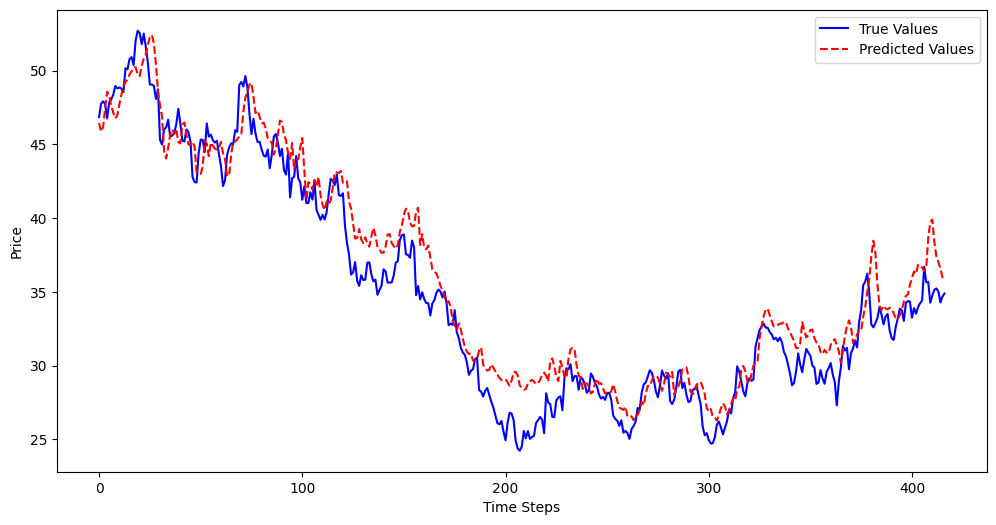

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

## Model: GRU

In [14]:
# Define the GRU model
gru = Sequential()

# Add the first GRU layer and some Dropout regularisation
gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru.add(Dropout(0.2))

# Add a second GRU layer and some Dropout regularisation
gru.add(GRU(units=50))
gru.add(Dropout(0.2))

# Add a Dense layer
gru.add(Dense(units=25))

# Output layer
gru.add(Dense(units=1))

# Compile the model
gru.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Checkpoint callback to save best model during training
checkpoint_filepath = f'/home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_gru_model_{symbol}.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mae', save_best_only=True, verbose=1)

# Early stopping callback to stop training when Mean Absolute Error stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

# Fit and train model
gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/1000
143/144 [============================>.] - ETA: 0s - loss: 199.2244 - mae: 11.0594
Epoch 1: val_mae improved from inf to 23.89050, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_gru_model_INTC.h5
144/144 [==============================] - 8s 40ms/step - loss: 198.6595 - mae: 11.0482 - val_loss: 597.6791 - val_mae: 23.8905
Epoch 2/1000
144/144 [==============================] - ETA: 0s - loss: 41.1154 - mae: 4.4932
Epoch 2: val_mae improved from 23.89050 to 7.49769, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_gru_model_INTC.h5
144/144 [==============================] - 6s 39ms/step - loss: 41.1154 - mae: 4.4932 - val_loss: 76.5084 - val_mae: 7.4977
Epoch 3/1000
143/144 [============================>.] - ETA: 0s - loss: 7.3987 - mae: 2.0602
Epoch 3: val_mae improved from 7.49769 to 5.95386, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-mo

144/144 [==============================] - ETA: 0s - loss: 4.0551 - mae: 1.4763
Epoch 26: val_mae did not improve from 2.71772
144/144 [==============================] - 6s 38ms/step - loss: 4.0551 - mae: 1.4763 - val_loss: 25.4948 - val_mae: 4.3302
Epoch 27/1000
143/144 [============================>.] - ETA: 0s - loss: 4.6109 - mae: 1.5970
Epoch 27: val_mae did not improve from 2.71772
144/144 [==============================] - 6s 38ms/step - loss: 4.6487 - mae: 1.6024 - val_loss: 19.8937 - val_mae: 3.6854
Epoch 28/1000
143/144 [============================>.] - ETA: 0s - loss: 3.8952 - mae: 1.4499
Epoch 28: val_mae improved from 2.71772 to 2.63306, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_gru_model_INTC.h5
144/144 [==============================] - 6s 38ms/step - loss: 3.8943 - mae: 1.4500 - val_loss: 11.6495 - val_mae: 2.6331
Epoch 29/1000
143/144 [============================>.] - ETA: 0s - loss: 4.2161 - mae: 1.5110
Epoch 29:

Epoch 54/1000
143/144 [============================>.] - ETA: 0s - loss: 2.4834 - mae: 1.0976
Epoch 54: val_mae did not improve from 2.02901
144/144 [==============================] - 6s 39ms/step - loss: 2.4996 - mae: 1.1033 - val_loss: 9.5845 - val_mae: 2.4679
Epoch 55/1000
144/144 [==============================] - ETA: 0s - loss: 2.3909 - mae: 1.0708
Epoch 55: val_mae did not improve from 2.02901
144/144 [==============================] - 6s 39ms/step - loss: 2.3909 - mae: 1.0708 - val_loss: 18.0478 - val_mae: 3.7605
Epoch 56/1000
143/144 [============================>.] - ETA: 0s - loss: 2.6653 - mae: 1.1479
Epoch 56: val_mae did not improve from 2.02901
144/144 [==============================] - 5s 38ms/step - loss: 2.6518 - mae: 1.1445 - val_loss: 10.0617 - val_mae: 2.5760
Epoch 57/1000
143/144 [============================>.] - ETA: 0s - loss: 2.5350 - mae: 1.1017
Epoch 57: val_mae did not improve from 2.02901
144/144 [==============================] - 6s 38ms/step - loss: 2.52

144/144 [==============================] - ETA: 0s - loss: 1.2477 - mae: 0.7695
Epoch 84: val_mae did not improve from 1.93054
144/144 [==============================] - 6s 43ms/step - loss: 1.2477 - mae: 0.7695 - val_loss: 13.7507 - val_mae: 3.1926
Epoch 85/1000
144/144 [==============================] - ETA: 0s - loss: 1.3836 - mae: 0.8228
Epoch 85: val_mae did not improve from 1.93054
144/144 [==============================] - 6s 41ms/step - loss: 1.3836 - mae: 0.8228 - val_loss: 10.5423 - val_mae: 2.7630
Epoch 86/1000
143/144 [============================>.] - ETA: 0s - loss: 1.4062 - mae: 0.8182
Epoch 86: val_mae did not improve from 1.93054
144/144 [==============================] - 6s 39ms/step - loss: 1.4183 - mae: 0.8204 - val_loss: 14.4362 - val_mae: 3.2339
Epoch 87/1000
144/144 [==============================] - ETA: 0s - loss: 1.2613 - mae: 0.7814
Epoch 87: val_mae did not improve from 1.93054
144/144 [==============================] - 6s 41ms/step - loss: 1.2613 - mae: 0.7

Epoch 115/1000
144/144 [==============================] - ETA: 0s - loss: 1.1617 - mae: 0.7723
Epoch 115: val_mae did not improve from 1.88412
144/144 [==============================] - 6s 39ms/step - loss: 1.1617 - mae: 0.7723 - val_loss: 15.2338 - val_mae: 3.3593
Epoch 116/1000
144/144 [==============================] - ETA: 0s - loss: 1.2490 - mae: 0.8076
Epoch 116: val_mae did not improve from 1.88412
144/144 [==============================] - 6s 41ms/step - loss: 1.2490 - mae: 0.8076 - val_loss: 13.5139 - val_mae: 3.1307
Epoch 117/1000
143/144 [============================>.] - ETA: 0s - loss: 1.1049 - mae: 0.7464
Epoch 117: val_mae did not improve from 1.88412
144/144 [==============================] - 6s 44ms/step - loss: 1.1041 - mae: 0.7465 - val_loss: 10.5867 - val_mae: 2.6420
Epoch 118/1000
144/144 [==============================] - ETA: 0s - loss: 1.1326 - mae: 0.7762
Epoch 118: val_mae did not improve from 1.88412
144/144 [==============================] - 6s 39ms/step - l

144/144 [==============================] - 6s 38ms/step - loss: 1.0393 - mae: 0.7417 - val_loss: 15.1662 - val_mae: 3.3254
Epoch 146/1000
143/144 [============================>.] - ETA: 0s - loss: 1.0719 - mae: 0.7437
Epoch 146: val_mae did not improve from 1.79743
144/144 [==============================] - 5s 38ms/step - loss: 1.0673 - mae: 0.7415 - val_loss: 12.7204 - val_mae: 2.9796
Epoch 147/1000
143/144 [============================>.] - ETA: 0s - loss: 1.1249 - mae: 0.7590
Epoch 147: val_mae did not improve from 1.79743
144/144 [==============================] - 5s 38ms/step - loss: 1.1237 - mae: 0.7585 - val_loss: 12.8125 - val_mae: 3.0152
Epoch 148/1000
143/144 [============================>.] - ETA: 0s - loss: 1.1235 - mae: 0.7714
Epoch 148: val_mae did not improve from 1.79743
144/144 [==============================] - 6s 41ms/step - loss: 1.1298 - mae: 0.7726 - val_loss: 19.4477 - val_mae: 3.7809
Epoch 149/1000
143/144 [============================>.] - ETA: 0s - loss: 1.050

143/144 [============================>.] - ETA: 0s - loss: 1.0375 - mae: 0.7347
Epoch 176: val_mae did not improve from 1.79743
144/144 [==============================] - 5s 38ms/step - loss: 1.0364 - mae: 0.7350 - val_loss: 20.5646 - val_mae: 3.9718
Epoch 177/1000
143/144 [============================>.] - ETA: 0s - loss: 1.0783 - mae: 0.7495
Epoch 177: val_mae did not improve from 1.79743
144/144 [==============================] - 6s 40ms/step - loss: 1.0786 - mae: 0.7499 - val_loss: 21.8405 - val_mae: 4.1563
Epoch 178/1000
144/144 [==============================] - ETA: 0s - loss: 1.0293 - mae: 0.7343
Epoch 178: val_mae did not improve from 1.79743
144/144 [==============================] - 6s 42ms/step - loss: 1.0293 - mae: 0.7343 - val_loss: 14.5013 - val_mae: 3.1305
Epoch 179/1000
143/144 [============================>.] - ETA: 0s - loss: 1.0158 - mae: 0.7191
Epoch 179: val_mae did not improve from 1.79743
144/144 [==============================] - 6s 40ms/step - loss: 1.0130 - m

Epoch 207/1000
143/144 [============================>.] - ETA: 0s - loss: 1.0369 - mae: 0.7364
Epoch 207: val_mae did not improve from 1.79743
144/144 [==============================] - 6s 40ms/step - loss: 1.0420 - mae: 0.7383 - val_loss: 20.3810 - val_mae: 3.9664
Epoch 208/1000
143/144 [============================>.] - ETA: 0s - loss: 0.9511 - mae: 0.7090
Epoch 208: val_mae did not improve from 1.79743
144/144 [==============================] - 6s 39ms/step - loss: 0.9507 - mae: 0.7092 - val_loss: 18.5049 - val_mae: 3.6358
Epoch 209/1000
143/144 [============================>.] - ETA: 0s - loss: 0.9402 - mae: 0.7060
Epoch 209: val_mae did not improve from 1.79743
144/144 [==============================] - 6s 39ms/step - loss: 0.9389 - mae: 0.7057 - val_loss: 17.9677 - val_mae: 3.5930
Epoch 210/1000
143/144 [============================>.] - ETA: 0s - loss: 1.0105 - mae: 0.7150
Epoch 210: val_mae did not improve from 1.79743
144/144 [==============================] - 6s 39ms/step - l

Epoch 238/1000
143/144 [============================>.] - ETA: 0s - loss: 0.9689 - mae: 0.7038
Epoch 238: val_mae did not improve from 1.79743
144/144 [==============================] - 6s 38ms/step - loss: 0.9709 - mae: 0.7045 - val_loss: 19.7442 - val_mae: 3.9526
Epoch 238: early stopping


In [15]:
y_pred_2 = gru.predict(X_test)
result_2 = pd.DataFrame(data={'Train Prediction': y_pred_2.flatten(), 'Actuals': y_test})
result_2.head()

14/14 [==============================] - 1s 12ms/step


,Train Prediction,Actuals
0,44.881516,46.854669
1,44.254311,47.769137
2,43.827339,47.919977
3,44.096668,47.721999
4,45.114868,46.760394


In [16]:
# Evaluate the model
loss_2 = gru.evaluate(X_test, y_test)
print('Test loss:', loss_2)

14/14 [==============================] - 0s 10ms/step - loss: 13.2999 - mae: 3.2561
Test loss: [13.299866676330566, 3.256108283996582]


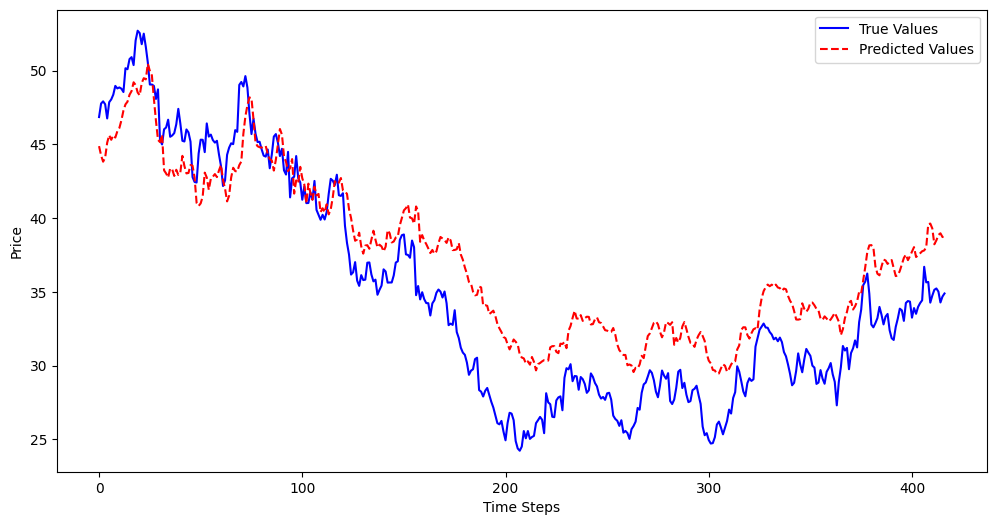

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(y_pred_2, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

## Model: CNN

In [18]:
# Define the CNN model
cnn = Sequential()

# Add the first Conv1D layer
cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn.add(MaxPooling1D(pool_size=2))

# Add a second Conv1D layer
cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))

# Flatten the data for input into the Dense layer
cnn.add(Flatten())

# Add a Dense layer
cnn.add(Dense(50, activation='relu'))

# Output layer
cnn.add(Dense(1))

# Compile the model
cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Checkpoint callback to save best model during training
checkpoint_filepath = f'/home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_cnn_model_{symbol}.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mae', save_best_only=True, verbose=1)

# Early stopping callback to stop training when Mean Absolute Error stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

# Fit and train model
cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/1000
138/144 [===========================>..] - ETA: 0s - loss: 83.8507 - mae: 4.9800
Epoch 1: val_mae improved from inf to 5.70779, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_cnn_model_INTC.h5
144/144 [==============================] - 2s 7ms/step - loss: 80.5700 - mae: 4.8407 - val_loss: 47.0061 - val_mae: 5.7078
Epoch 2/1000
134/144 [==========================>...] - ETA: 0s - loss: 3.5726 - mae: 1.4326
Epoch 2: val_mae improved from 5.70779 to 4.88845, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_cnn_model_INTC.h5
144/144 [==============================] - 1s 6ms/step - loss: 3.5411 - mae: 1.4275 - val_loss: 34.5465 - val_mae: 4.8885
Epoch 3/1000
140/144 [============================>.] - ETA: 0s - loss: 2.9100 - mae: 1.2771
Epoch 3: val_mae improved from 4.88845 to 4.65918, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_cn

136/144 [===========================>..] - ETA: 0s - loss: 1.1997 - mae: 0.7899
Epoch 29: val_mae did not improve from 2.82666
144/144 [==============================] - 1s 6ms/step - loss: 1.1915 - mae: 0.7867 - val_loss: 16.0079 - val_mae: 3.3322
Epoch 30/1000
140/144 [============================>.] - ETA: 0s - loss: 1.0573 - mae: 0.7311
Epoch 30: val_mae improved from 2.82666 to 2.65611, saving model to /home/adedapo/personal_project/daps05ayoade/disseration/alternative-models/best_cnn_model_INTC.h5
144/144 [==============================] - 1s 5ms/step - loss: 1.0630 - mae: 0.7337 - val_loss: 10.4445 - val_mae: 2.6561
Epoch 31/1000
137/144 [===========================>..] - ETA: 0s - loss: 1.1208 - mae: 0.7636
Epoch 31: val_mae did not improve from 2.65611
144/144 [==============================] - 1s 6ms/step - loss: 1.1441 - mae: 0.7718 - val_loss: 16.6596 - val_mae: 3.4007
Epoch 32/1000
134/144 [==========================>...] - ETA: 0s - loss: 0.9877 - mae: 0.7047
Epoch 32: va

Epoch 59/1000
141/144 [============================>.] - ETA: 0s - loss: 0.7013 - mae: 0.5887
Epoch 59: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 5ms/step - loss: 0.7026 - mae: 0.5885 - val_loss: 23.1569 - val_mae: 4.2656
Epoch 60/1000
140/144 [============================>.] - ETA: 0s - loss: 0.7284 - mae: 0.5991
Epoch 60: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 5ms/step - loss: 0.7217 - mae: 0.5954 - val_loss: 22.8370 - val_mae: 4.2279
Epoch 61/1000
133/144 [==========================>...] - ETA: 0s - loss: 0.6965 - mae: 0.6002
Epoch 61: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 6ms/step - loss: 0.7325 - mae: 0.6175 - val_loss: 16.3529 - val_mae: 3.4741
Epoch 62/1000
137/144 [===========================>..] - ETA: 0s - loss: 0.7219 - mae: 0.6046
Epoch 62: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 6ms/step - loss: 0.7203 

138/144 [===========================>..] - ETA: 0s - loss: 0.5571 - mae: 0.5357
Epoch 90: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 5ms/step - loss: 0.5517 - mae: 0.5319 - val_loss: 13.2976 - val_mae: 3.0551
Epoch 91/1000
137/144 [===========================>..] - ETA: 0s - loss: 0.5136 - mae: 0.5166
Epoch 91: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 6ms/step - loss: 0.5136 - mae: 0.5183 - val_loss: 31.7553 - val_mae: 5.0935
Epoch 92/1000
138/144 [===========================>..] - ETA: 0s - loss: 0.5083 - mae: 0.5155
Epoch 92: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 5ms/step - loss: 0.5041 - mae: 0.5132 - val_loss: 20.4278 - val_mae: 3.9668
Epoch 93/1000
140/144 [============================>.] - ETA: 0s - loss: 0.4815 - mae: 0.5076
Epoch 93: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 5ms/step - loss: 0.4893 - mae: 0.5104 

136/144 [===========================>..] - ETA: 0s - loss: 0.3261 - mae: 0.4194
Epoch 121: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 6ms/step - loss: 0.3340 - mae: 0.4243 - val_loss: 14.9726 - val_mae: 3.2303
Epoch 122/1000
138/144 [===========================>..] - ETA: 0s - loss: 0.4877 - mae: 0.5145
Epoch 122: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 6ms/step - loss: 0.4795 - mae: 0.5078 - val_loss: 18.5442 - val_mae: 3.6747
Epoch 123/1000
143/144 [============================>.] - ETA: 0s - loss: 0.3643 - mae: 0.4360
Epoch 123: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 7ms/step - loss: 0.3640 - mae: 0.4363 - val_loss: 16.1363 - val_mae: 3.4060
Epoch 124/1000
144/144 [==============================] - ETA: 0s - loss: 0.3292 - mae: 0.4243
Epoch 124: val_mae did not improve from 2.50751
144/144 [==============================] - 1s 8ms/step - loss: 0.3292 - mae: 

In [19]:
y_pred_3 = cnn.predict(X_test)
result_3 = pd.DataFrame(data={'Train Prediction': y_pred_3.flatten(), 'Actuals': y_test})
result_3.head()

14/14 [==============================] - 0s 5ms/step


,Train Prediction,Actuals
0,57.355251,46.854669
1,57.725975,47.769137
2,55.506023,47.919977
3,56.437855,47.721999
4,54.764412,46.760394


In [20]:
# Evaluate the model
loss_3 = cnn.evaluate(X_test, y_test)
print('Test loss:', loss_3)

14/14 [==============================] - 0s 5ms/step - loss: 135.9356 - mae: 11.4090
Test loss: [135.9355926513672, 11.409018516540527]


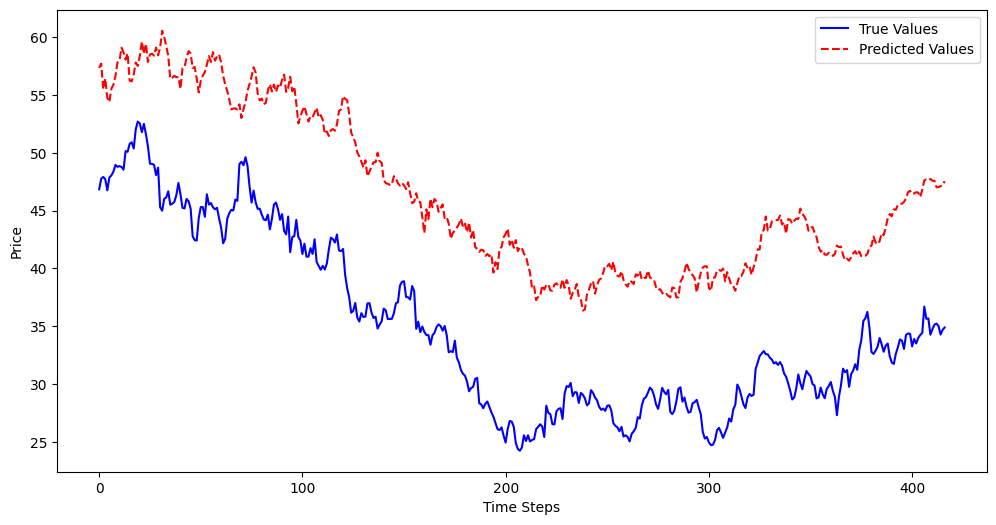

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(y_pred_3, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()